In [1]:
import sys, os

import matplotlib  
matplotlib.use('Agg')  
from matplotlib import pyplot as plt
from matplotlib.pyplot import savefig

%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from scipy.io import loadmat, savemat

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_null',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import numpy as np
from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand

print "I'm using scipy version:" 
scipy.__version__

I'm using scipy version:


'0.13.3'

In [146]:
#### self-defined functions to find fluxes shifted between different sampling distributions
#from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
#from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore

import fluxShift
reload(fluxShift)
from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore


In [4]:
model = cobra.io.load_json_model("HNC47.json")
react_id = "RecombinantProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Recombinant protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0

metabolites = ['ala__L_c','cys__L_c','asp__L_c','glu__L_c','phe__L_c','gly_c','his__L_c','ile__L_c','lys__L_c','leu__L_c','met__L_c','asn__L_c','pro__L_c','gln__L_c','arg__L_c','ser__L_c','thr__L_c','val__L_c','trp__L_c','tyr__L_c','atp_c','adp_c','pi_c']
coefficient1 = [-6,-6,-9,-17,-9,-11,-5,-4,-17,-17,-3,-11,-19,-11,-6,-24,-14,-23,-4,-8,-4.306*224,964.544,965.544]
coefficient2 = [-0.513689,-0.09158,-0.241055,-0.26316,-0.185265,-0.612638,-0.094738,-0.290529,-0.343161,-0.450531,-0.153686,-0.241055,-0.221055,-0.26316,-0.295792,-0.215792,-0.253687,-0.423162,-0.056843,-0.137896,-23.03053,23.03053,23.03053]
for


In [5]:
print len(model.reactions)

2786


In [6]:
m = model.copy()
m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
m.reactions.EX_glc__D_e.lower_bound = -0.5

# Find Loops/zero flux reactions in M model
loops = []
read_to_struct =[]
for r in m.reactions:
    r.objective_coefficient = 1.0  
    m.optimize()
    if m.solution.f > 100:
        read_to_struct.append({'reaction':r.id, 'flux':m.solution.f})
        loops.append(r.id)
    
    r.objective_coefficient = 0

DF_erroneous_fluxes = pd.DataFrame(read_to_struct)

#  search for zero flux reactions

opt_fract = 0.9

from cobra.flux_analysis.variability import flux_variability_analysis
flux_var = flux_variability_analysis(m, fraction_of_optimum=opt_fract)

removed = []
read_to_struct = []

for r in m.reactions:
    # 1 fix numerical errors
    if flux_var[r.id]['minimum'] > flux_var[r.id]['maximum']:
        min_val = np.round(flux_var[r.id]['minimum'],9)
        max_val = np.round(flux_var[r.id]['maximum'],9)
        flux_var[r.id]['minimum'] = max_val
        flux_var[r.id]['maximum'] = min_val
        
    # 2 constrain bounds to FVA results
    r.lower_bound = flux_var[r.id]['minimum']
    r.upper_bound = flux_var[r.id]['maximum']
    
    # 3 remove reactions that cannot carry flux
    if r.lower_bound==0 and r.upper_bound==0:
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
        m.optimize()
        
        if m.solution.f == None:
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'no'})
        else:
            removed.append(r.id)
            m.remove_reactions(r)
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'yes'})
            
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0   
        
DF_zero_flux_reactions = pd.DataFrame(read_to_struct)


cobra/core/Model.py:306 UserWarning: need to pass in a list


In [7]:
## Remove reactions from sampling dataframes
reactions_to_remove = DF_zero_flux_reactions.reaction[DF_zero_flux_reactions['removed?']=='yes'].tolist() + DF_erroneous_fluxes.reaction.tolist()
print "number of total reactions:", len(DF_zero_flux_reactions[DF_zero_flux_reactions['removed?']=='yes'])+len(DF_erroneous_fluxes.reaction)


number of total reactions: 750


In [102]:
# load R sybil MCMC sampling trajectories into ipython
from collections import defaultdict

def mcmc_tab2pandas(strain):

    file1 = '25glucose+10YE/sampling_%s_p1.tab'%strain
    file2 = '25glucose+10YE/sampling_%s_p2.tab'%strain
    file2 = '25glucose+10YE/sampling_%s_p3.tab'%strain
    
    flux_dist1 = np.loadtxt(file1,delimiter="\t",skiprows=1)
    flux_dist2 = np.loadtxt(file2,delimiter="\t",skiprows=1)
    flux_dist3 = np.loadtxt(file2,delimiter="\t",skiprows=1)

    print "Sample size for %s phase I:"%strain, flux_dist1.shape
    print "Sample size for %s phase II:"%strain, flux_dist2.shape
    print "Sample size for %s phase III:"%strain, flux_dist3.shape
    
    # now convert flux_dist array into pandas df with reaction field
    
    model_rxns=[]

    samples1 = defaultdict(list)
    samples2 = defaultdict(list)
    samples3 = defaultdict(list)
    
    tmp_array = []
    for react in model.reactions:
        tmp_array.append(react.id)

    count = 0
    for i in tmp_array:
        rxn_name = str(i)
        model_rxns.append(str(i))
    
        samples1[rxn_name] = flux_dist1[count,:]
        samples2[rxn_name] = flux_dist2[count,:]
        samples3[rxn_name] = flux_dist3[count,:]
    
        count +=1

    # convert to dataframes    
    df_samples1 = pd.DataFrame(samples1)
    df_samples2 = pd.DataFrame(samples2)
    df_samples3 = pd.DataFrame(samples3)  

    print "number of reactions in df:", len(model_rxns)

    return (df_samples1,df_samples2,df_samples3)

################################################################################


In [103]:
mcmc_reduced_dict_p1 = {}
mcmc_reduced_dict_p2 = {}
mcmc_reduced_dict_p3 = {}

mcmc_p1_dict = {}
mcmc_p2_dict = {}
mcmc_p3_dict = {}

In [104]:
mylegend = ['50%glc','25%glc_10%YE']

In [107]:
for strain in mylegend:
    (mcmc_p1_dict[strain],mcmc_p2_dict[strain],mcmc_p3_dict[strain]) = mcmc_tab2pandas(strain)
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    df_reduced_p2 = remove_unwanted_rxns(mcmc_p2_dict[strain],reactions_to_remove)
    df_reduced_p3 = remove_unwanted_rxns(mcmc_p3_dict[strain],reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    mcmc_reduced_dict_p2[strain] = df_reduced_p2
    mcmc_reduced_dict_p3[strain] = df_reduced_p3
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p2[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p3[strain].shape


 Sample size for 50%glc phase I: (2786, 5000)
Sample size for 50%glc phase II: (2786, 5000)
Sample size for 50%glc phase III: (2786, 5000)
number of reactions in df: 2786
Strain 50%glc (5000, 2036)
Strain 50%glc (5000, 2036)
Strain 50%glc (5000, 2036)
Sample size for 25%glc_10%YE phase I: (2786, 5000)
Sample size for 25%glc_10%YE phase II: (2786, 5000)
Sample size for 25%glc_10%YE phase III: (2786, 5000)
number of reactions in df: 2786
Strain 25%glc_10%YE (5000, 2036)
Strain 25%glc_10%YE (5000, 2036)
Strain 25%glc_10%YE (5000, 2036)


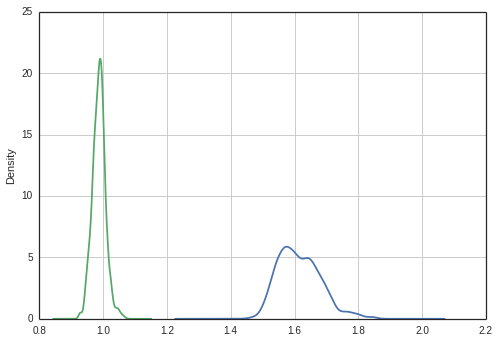

In [108]:
react = 'CS'

mcmc_reduced_dict_p1['50%glc'][react].plot(kind='density')
mcmc_reduced_dict_p1['25%glc_10%YE'][react].plot(kind='density')

savefig('CS.jpg')

In [109]:
#########################################################

# Perform further pruning of flux distributions
# Note: none of the remaining reactions have a significant amount of fluxes above the threshold:
#       No reactions have fluxes greater than 10 x glc uptake for > 99% of flux states
#       No reactions have fluxes greater than 20 x glc uptake

df_rxns_removed_p1 = {}
df_rxns_removed_p2 = {}
df_rxns_removed_p3 = {}

df_rxns_high_flux_remain_p1 = {}
df_rxns_high_flux_remain_p2 = {}
df_rxns_high_flux_remain_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():

    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    [mcmc_reduced_dict_p2[strain], df_rxns_removed_p2[strain], df_rxns_high_flux_remain_p2[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p2[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p3[strain].shape
    [mcmc_reduced_dict_p3[strain], df_rxns_removed_p3[strain], df_rxns_high_flux_remain_p3[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p3[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p3[strain].shape


shape before pruning 25%glc_10%YE: (5000, 2036)
shape after pruning 25%glc_10%YE: (5000, 2006)
shape before pruning 25%glc_10%YE: (5000, 2036)
shape after pruning 25%glc_10%YE: (5000, 2006)
shape before pruning 25%glc_10%YE: (5000, 2036)
shape after pruning 25%glc_10%YE: (5000, 2006)
shape before pruning 50%glc: (5000, 2036)
shape after pruning 50%glc: (5000, 2008)
shape before pruning 50%glc: (5000, 2036)
shape after pruning 50%glc: (5000, 2008)
shape before pruning 50%glc: (5000, 2036)
shape after pruning 50%glc: (5000, 2008)


In [110]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['25%glc_10%YE']

for i in df.index:
    if df['percent of states with flux < 10'][i] < 4900:
        print df['react_id'][i], df['percent of states with flux < 10'][i]

for i in df.index:
    if df['percent of states with flux < 10'][i] < 5000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]

2HH24DDH1_copy2 0
ACKr 0
ACt2rpp 84
ALAt2pp_copy2 0
ASPt2pp_copy2 167
CAt6pp 0
CRNt2rpp 0
CYTDt2pp_copy2 0
EX_fe2_e 0
EX_h_e 0
FE3tex 0
GLUt2rpp 0
GLYBt2pp_copy2 0
GLYCLTt2rpp 748
GLYt2pp_copy2 0
H2Otex 0
HPYRI 0
ICHORS_copy1 0
INSTt2 0
PPKr 0
PPM 0
PRASCSi_copy2 0
PROt2rpp 958
PRPPS 0
SERt2rpp 0
SUCOAS 0
THRt2rpp 0
TRSARr 0
URAt2pp_copy2 0
URIt2pp_copy2 0
2HH24DDH1_copy2 999.997897782
ACKr 776.63020809
ACt2rpp 316.405052669
ALAt2pp_copy2 999.986077899
ASPt2pp_copy2 410.803849551
CAt6pp 810.761521373
CRNt2rpp 999.676382219
CYTDt2pp_copy2 984.194563707
EX_fe2_e 32.9549305282
EX_h_e 32.0226647822
FE3tex 33.0081638515
GLUt2rpp 915.306859367
GLYBt2pp_copy2 769.49210812
GLYCLTt2rpp 155.438531443
GLYt2pp_copy2 999.999103055
H2Otex 22.5484933912
HPYRI 928.383962881
ICHORS_copy1 522.947413677
INSTt2 963.021873776
PPKr 962.363422461
PPM 492.635942735
PRASCSi_copy2 999.960707123
PROt2rpp 294.274841626
PRPPS 492.4490416
SERt2rpp 658.102383534
SUCOAS 952.800009576
THRt2rpp 402.751177474
TRSARr 928

In [111]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given culture conditions
# or, between culture conditions1 - culture conditions2 for a given phase
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1 = {}
flux_stats_dict_p2 = {}
flux_stats_dict_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        if strain == '50%glc':
            continue

        print "strain:", strain
        
        flux_stats_dict_p1[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1['50%glc'],mcmc_reduced_dict_p1[strain], m, 1, 2)
        flux_stats_dict_p2[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p2['50%glc'],mcmc_reduced_dict_p2[strain], m, 1, 2)
        flux_stats_dict_p3[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p3['50%glc'],mcmc_reduced_dict_p3[strain], m, 1, 2)

strain: 25%glc_10%YE


In [112]:
# Note: here we have the mean, median and std for the flux distributions in phases 1 and 2.
# The pval indicates whether the sample difference between these two states is significant.
flux_stats_dict_p1['25%glc_10%YE'][0:3]

,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,2.80e-05,2.80e-05,6.06e-07,2.14e-05,2.14e-05,5.44e-07,4.00e-04,DM_4crsol_c
1,3.01e-04,2.37e-04,2.38e-04,1.29e-04,1.03e-04,9.07e-05,4.97e-01,DM_5drib_c
2,2.51e-07,2.51e-07,5.43e-09,1.92e-07,1.92e-07,4.88e-09,4.00e-04,DM_amob_c


In [113]:
# Classify Flux shifts

flux_shift_stats_dict_p1 ={}
m_significant_shifts_dict_p1 ={}

flux_shift_stats_dict_p2 ={}
m_significant_shifts_dict_p2 ={}

flux_shift_stats_dict_p3 ={}
m_significant_shifts_dict_p3 ={}

for strain in flux_stats_dict_p1.keys():
    print "strain:", strain
    df = flux_stats_dict_p1[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict_p1[strain] = df
    m_significant_shifts_dict_p1[strain] = change

for strain in flux_stats_dict_p2.keys():
    print "strain:", strain
    df = flux_stats_dict_p2[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict_p2[strain] = df
    m_significant_shifts_dict_p2[strain] = change

for strain in flux_stats_dict_p3.keys():
    print "strain:", strain
    df = flux_stats_dict_p3[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict_p3[strain] = df
    m_significant_shifts_dict_p3[strain] = change

strain: 25%glc_10%YE
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1618
do shift 32 

strain: 25%glc_10%YE
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1628
do shift 23 

strain: 25%glc_10%YE
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1628
do shift 23 



In [115]:
print m_significant_shifts_dict_p1['25%glc_10%YE'].reaction.values

m_significant_shifts_dict_p1['25%glc_10%YE'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'AKGDH' 'ASPTA' 'CS' 'CYTK1' 'DRPA' 'ENO' 'FUM' 'G3PD2'
 'G6PDH2r' 'GAPD' 'GK1' 'GLNS' 'GLUDy' 'GND' 'HCO3E' 'ICDHyr' 'MDH' 'NDPK3'
 'PDH' 'PGCD' 'PGK' 'PGM' 'PPC' 'PPM2' 'PSERT' 'PSP_L' 'RPI' 'TPI' 'XYLI2'
 'PGL']


Citric Acid Cycle                   7
Glycolysis/Gluconeogenesis          6
Pentose Phosphate Pathway           4
Alternate Carbon Metabolism         4
Nucleotide Salvage Pathway          3
Glycine and Serine Metabolism       3
Glutamate Metabolism                2
Anaplerotic Reactions               1
Alanine and Aspartate Metabolism    1
Unassigned                          1
dtype: int64

In [161]:
print m_significant_shifts_dict_p2['25%glc_10%YE'].reaction.values

m_significant_shifts_dict_p2['25%glc_10%YE'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'AKGDH' 'ASPTA' 'ATPM' 'CS' 'CYTK1' 'DHAPT' 'ENO' 'F6PA'
 'FRD3' 'FUM' 'GAPD' 'GLUDy' 'ICDHyr' 'MDH' 'NDPK3' 'PDH' 'PGI' 'PGK' 'PGM'
 'SUCDi' 'TPI']


Glycolysis/Gluconeogenesis          8
Citric Acid Cycle                   8
Nucleotide Salvage Pathway          2
Glutamate Metabolism                1
Alternate Carbon Metabolism         1
Alanine and Aspartate Metabolism    1
Oxidative Phosphorylation           1
Unassigned                          1
dtype: int64

In [162]:
print m_significant_shifts_dict_p3['25%glc_10%YE'].reaction.values

m_significant_shifts_dict_p3['25%glc_10%YE'].subsystem.value_counts()

['ACONTa' 'ACONTb' 'AKGDH' 'ASPTA' 'ATPM' 'CS' 'CYTK1' 'DHAPT' 'ENO' 'F6PA'
 'FRD3' 'FUM' 'GAPD' 'GLUDy' 'ICDHyr' 'MDH' 'NDPK3' 'PDH' 'PGI' 'PGK' 'PGM'
 'SUCDi' 'TPI']


Glycolysis/Gluconeogenesis          8
Citric Acid Cycle                   8
Nucleotide Salvage Pathway          2
Glutamate Metabolism                1
Alternate Carbon Metabolism         1
Alanine and Aspartate Metabolism    1
Oxidative Phosphorylation           1
Unassigned                          1
dtype: int64

In [116]:
# Compute Z score per reaction difference

DF_reaction_zscore_p1 = {}
DF_reaction_zscore_p2 = {}
DF_reaction_zscore_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        if strain == '50%glc':
            continue
        
        print "strain:", strain
        
        DF_reaction_zscore_p1[strain] = get_zscore(mcmc_reduced_dict_p1['50%glc'],mcmc_reduced_dict_p1[strain],m,flux_shift_stats_dict_p1,strain)
        DF_reaction_zscore_p2[strain] = get_zscore(mcmc_reduced_dict_p2['50%glc'],mcmc_reduced_dict_p2[strain],m,flux_shift_stats_dict_p2,strain)
        DF_reaction_zscore_p3[strain] = get_zscore(mcmc_reduced_dict_p3['50%glc'],mcmc_reduced_dict_p3[strain],m,flux_shift_stats_dict_p3,strain)
        

***PROGRESS: 2133/2134 reactions***



In [117]:
DF_reaction_zscore_p1['25%glc_10%YE'][0:10]

,reaction,z_score
0,DM_4crsol_c,0.12
1,DM_5drib_c,0.12
2,DM_amob_c,0.12
3,DM_mththf_c,0.12
4,DM_oxam_c,0.11
5,BIOMASS_Ec_iJO1366_WT_53p95M,0.12
6,BIOMASS_Ec_iJO1366_core_53p95M,0.04
7,EX_12ppd__R_e,0.11
8,EX_12ppd__S_e,0.12
9,EX_15dap_e,0.12


In [118]:
for strain in DF_reaction_zscore_p1.keys():
    file1 = '%s_p1_reaction_zscore.csv'%strain
    file2 = '%s_p2_reaction_zscore.csv'%strain
    file3 = '%s_p3_reaction_zscore.csv'%strain
    DF_reaction_zscore_p1[strain].to_csv(file1)
    DF_reaction_zscore_p2[strain].to_csv(file2)
    DF_reaction_zscore_p3[strain].to_csv(file3)


In [121]:
# Compute met Z scores
DF_metabolite_zscore_p1 = {}
DF_metabolite_zscore_p2 = {}
DF_metabolite_zscore_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        if strain == '50%glc':
            continue

        DF_metabolite_zscore_p1[strain] = get_met_zscore(mcmc_reduced_dict_p1['50%glc'],mcmc_reduced_dict_p1[strain],m,DF_reaction_zscore_p1,strain)
        DF_metabolite_zscore_p2[strain] = get_met_zscore(mcmc_reduced_dict_p2['50%glc'],mcmc_reduced_dict_p2[strain],m,DF_reaction_zscore_p2,strain)
        DF_metabolite_zscore_p3[strain] = get_met_zscore(mcmc_reduced_dict_p3['50%glc'],mcmc_reduced_dict_p3[strain],m,DF_reaction_zscore_p2,strain)
        

strain: 25%glc_10%YE
strain: 50%glc


In [122]:
DF_metabolite_zscore_p1['25%glc_10%YE'][0:10]

,metabolite,num_rxns_involved,zscore
0,10fthf_c,7,0.15
1,12dgr120_c,3,0.20
2,12dgr140_c,3,0.20
3,12dgr141_c,3,0.19
4,12dgr160_c,3,0.19
5,12dgr161_c,3,0.22
6,12dgr180_c,3,0.22
7,12dgr181_c,3,0.20
8,12ppd__R_c,3,0.09
9,12ppd__S_c,2,0.14


In [123]:
DF_metabolite_zscore_p2.keys()

['25%glc_10%YE']

In [124]:
for strain in DF_metabolite_zscore_p1.keys():
    file1 = '%s_p1_metabolite_zscore.csv'%strain
    file2 = '%s_p2_metabolite_zscore.csv'%strain
    file3 = '%s_p3_metabolite_zscore.csv'%strain
    DF_metabolite_zscore_p1[strain].to_csv(file1)
    DF_metabolite_zscore_p2[strain].to_csv(file2)
    DF_metabolite_zscore_p3[strain].to_csv(file3)


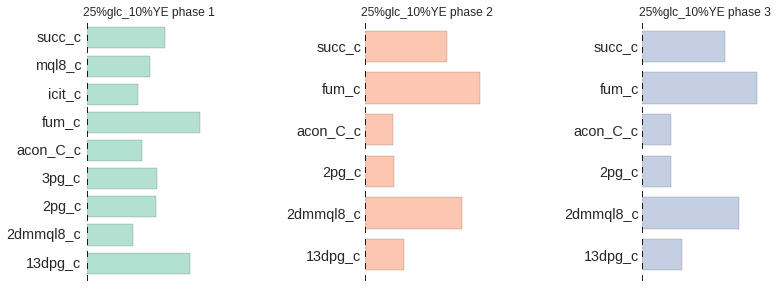

In [130]:
metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'metabolite_zscores_all_strains'
    
fig, axes = plt.subplots(nrows=1, ncols=3)  # change for adding in bis

c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

strain = "25%glc_10%YE"
df =  DF_metabolite_zscore_p1[strain][~DF_metabolite_zscore_p1[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p1[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p1[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[0], kind='barh', color=c1, title=strain + " phase 1",alpha=0.5,figsize=(5, 8))
axes[0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')


df =  DF_metabolite_zscore_p2[strain][~DF_metabolite_zscore_p2[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p2[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p2[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[1], kind='barh', color=c2, title=strain + " phase 2",alpha=0.5,figsize=(5, 8))
axes[1].axis('off')

for i, x in enumerate(df.metabolite):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')

df =  DF_metabolite_zscore_p3[strain][~DF_metabolite_zscore_p3[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore_p3[strain].metabolite.str.contains('_c')][DF_metabolite_zscore_p3[strain].zscore >1.74]
    
df.zscore.plot(ax=axes[2], kind='barh', color=c3, title=strain + " phase 3",alpha=0.5,figsize=(5, 8))
axes[2].axis('off')

for i, x in enumerate(df.metabolite):
        axes[2].text(-0.25, i + .5, x, ha='right', fontsize='large')

####

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(4)

In [131]:
fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

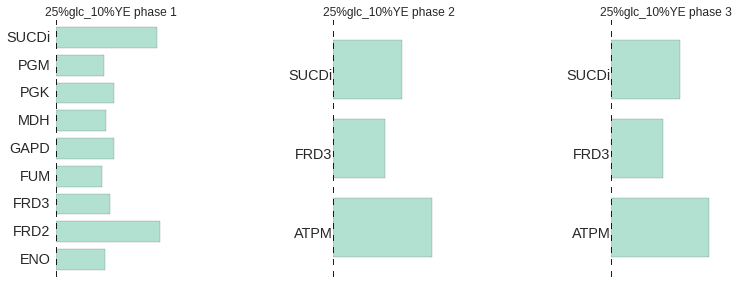

In [170]:
name_graph = 'reaction_zscores_all_strains'
    
fig, axes = plt.subplots(nrows=1, ncols=3)  # change for adding in bis

c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette("Set2", 8)

strain = "25%glc_10%YE"
df = DF_reaction_zscore_p1[strain][~DF_reaction_zscore_p1[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p1[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p1[strain].reaction.str.contains('pp')][DF_reaction_zscore_p1[strain].z_score > 1.74]

df.z_score.plot(ax=axes[0], kind='barh', color=c1, title=strain + " phase 1",alpha=0.5,figsize=(5, 7))
axes[0].axis('off')

for i, x in enumerate(df.reaction):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')

df = DF_reaction_zscore_p2[strain][~DF_reaction_zscore_p2[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p2[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p2[strain].reaction.str.contains('pp')][DF_reaction_zscore_p2[strain].z_score > 1.74]

df.z_score.plot(ax=axes[1], kind='barh', color=c1, title=strain + " phase 2",alpha=0.5,figsize=(5, 7))
axes[1].axis('off')

for i, x in enumerate(df.reaction):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')

df = DF_reaction_zscore_p3[strain][~DF_reaction_zscore_p3[strain].reaction.str.contains('ex')][~DF_reaction_zscore_p3[strain].reaction.str.contains('EX')][~DF_reaction_zscore_p3[strain].reaction.str.contains('pp')][DF_reaction_zscore_p3[strain].z_score > 1.74]

df.z_score.plot(ax=axes[2], kind='barh', color=c1, title=strain + " phase 3",alpha=0.5,figsize=(5, 7))
axes[2].axis('off')

for i, x in enumerate(df.reaction):
        axes[2].text(-0.25, i + .5, x, ha='right', fontsize='large')

####


fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(4)

In [85]:
fig.savefig('%s.pdf'%str(),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


In [139]:
for i, x in enumerate(df.reaction):
    print m.reactions.get_by_id(x).subsystem + ": " + x






Unassigned: ATPM
Citric Acid Cycle: FRD3
Oxidative Phosphorylation: SUCDi


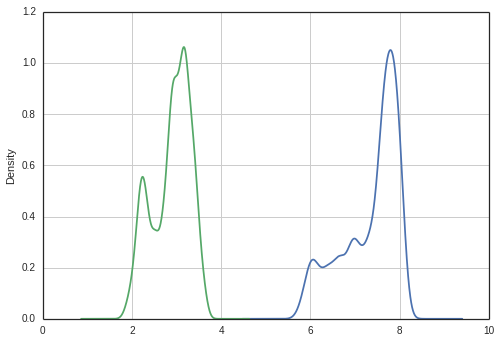

In [143]:
react = 'SUCDi'

mcmc_reduced_dict_p2['50%glc'][react].plot(kind='density')
mcmc_reduced_dict_p2['25%glc_10%YE'][react].plot(kind='density')


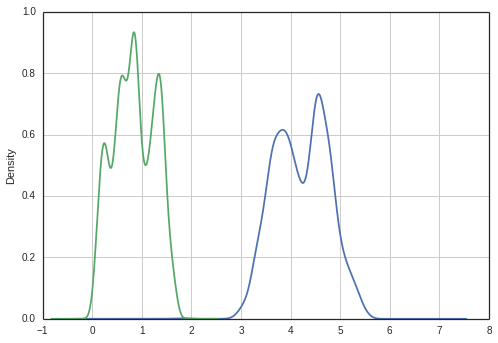

In [144]:
react = 'FRD3'

mcmc_reduced_dict_p2['50%glc'][react].plot(kind='density')
mcmc_reduced_dict_p2['25%glc_10%YE'][react].plot(kind='density')


Fumarate reductase


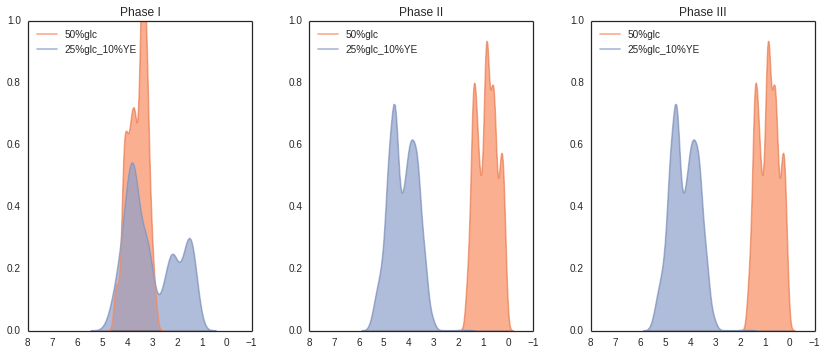

In [147]:
react = 'FRD3'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2,mcmc_reduced_dict_p3, react, -1, 8, 1)


In [148]:
fig.savefig('%s.pdf'%str(react),dpi=600,format='PDF')
fig.savefig('%s.png'%str(react),dpi=300,format='PNG')

Succinate dehydrogenase (irreversible)


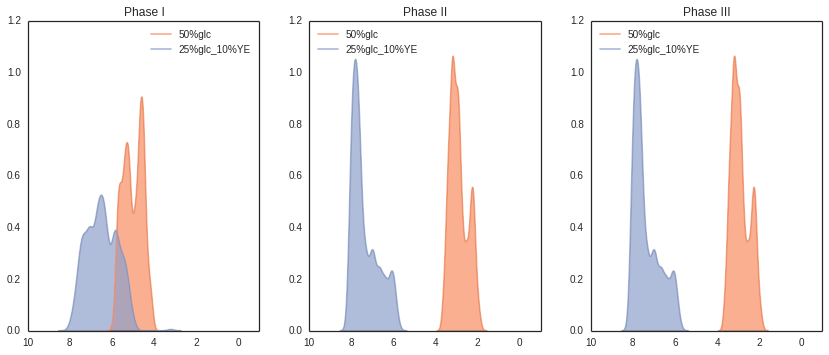

In [151]:
react = 'SUCDi'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2,mcmc_reduced_dict_p3, react, -1, 10, 1.2)


In [152]:
fig.savefig('%s.pdf'%str(react),dpi=600,format='PDF')
fig.savefig('%s.png'%str(react),dpi=300,format='PNG')

6-phosphogluconolactonase


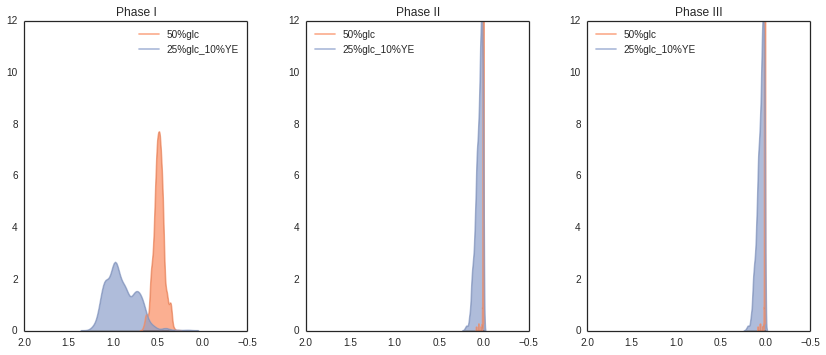

In [168]:
react = 'PGL'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2,mcmc_reduced_dict_p3, react, -0.5, 2, 12)


In [169]:
fig.savefig('%s.pdf'%str(react),dpi=600,format='PDF')
fig.savefig('%s.png'%str(react),dpi=300,format='PNG')